In [1]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [3]:
files = os.listdir(path)

In [4]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [5]:
images = [kb.layered_image(f) for f in files]

In [6]:
p = kb.psf(1.4)

In [7]:
object_count = 2000
x_range = (200,3650)
y_range = (200, 3650)
xv_range = (2100,2450)
yv_range = (800,1100)
angle_range = tuple( math.atan(yv/xv) for xv,yv in zip(xv_range, yv_range))
velocity_range = tuple( math.sqrt(xv**2+yv**2) for xv,yv in zip(xv_range, yv_range))
flux_range = (500, 6500)

In [8]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    traj.x_v = rd.uniform(*xv_range)
    traj.y_v = rd.uniform(*yv_range)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

In [9]:
results_key[0]

lh: 0.000000 flux: 3826.717773 x: 242 y: 523 x_v: 2102.067383 y_v: 809.314514 obs_count: 0

In [10]:
clustered = cluster_trajectories(results_key, dbscan_args=dict(eps=0.06, min_samples=1))
len(clustered[1])

1898

In [11]:
for t in results_key:
    add_trajectory(images, t, p)

In [12]:
len(match_trajectories(results_key, results_key, 0.05))

2000

In [13]:
stack = kb.image_stack(images)

In [14]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [15]:
stack.apply_mask_flags(flags, flag_exceptions)

In [16]:
stack.apply_master_mask(master_flags, 2)

In [17]:
images = [i.science() for i in stack.get_images()]

In [18]:
img = images[1] #kb.layered_image("test",4096, 4096, 20.0, 400.0, 0.0)#

In [19]:
img = img[2700:3600,2900:3800]

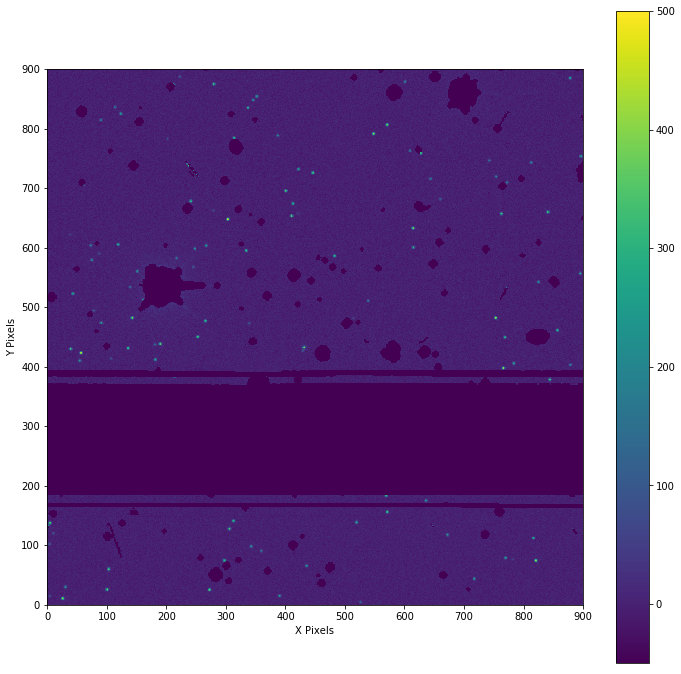

In [20]:
fig = plt.figure(figsize=(12,12))
plt.imshow(img, origin='lower',  vmin=-50, vmax=500)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [21]:
search = kb.stack_search(stack, p)

In [22]:
search.gpu(80,80, *angle_range, *velocity_range)

In [23]:
search.filter_min_obs(3)

In [24]:
results = search.get_results(0, 1500000)

In [25]:
#results = [t for t in results if t.obs_count>=2]

In [26]:
len(results)

1500000

In [27]:
results_clustered = [ results[i] for i in cluster_trajectories(results, dbscan_args=dict(eps=0.018, min_samples=1))[1] ]

In [28]:
#search.save_results("filtered.txt", 0.01)

In [29]:
len(results_clustered)

2045

In [30]:
#results_clustered

In [31]:
#results_key

In [32]:
results_matched = match_trajectories(results_clustered, results_key, 0.01)
print(len(results_matched))
#matched_trajectories

471


In [33]:
results_to_plot = results_matched

In [34]:
stamps = [create_postage_stamp(images, t, stack.get_times(), [21,21])[0] for t in results_to_plot]

Starting at 0


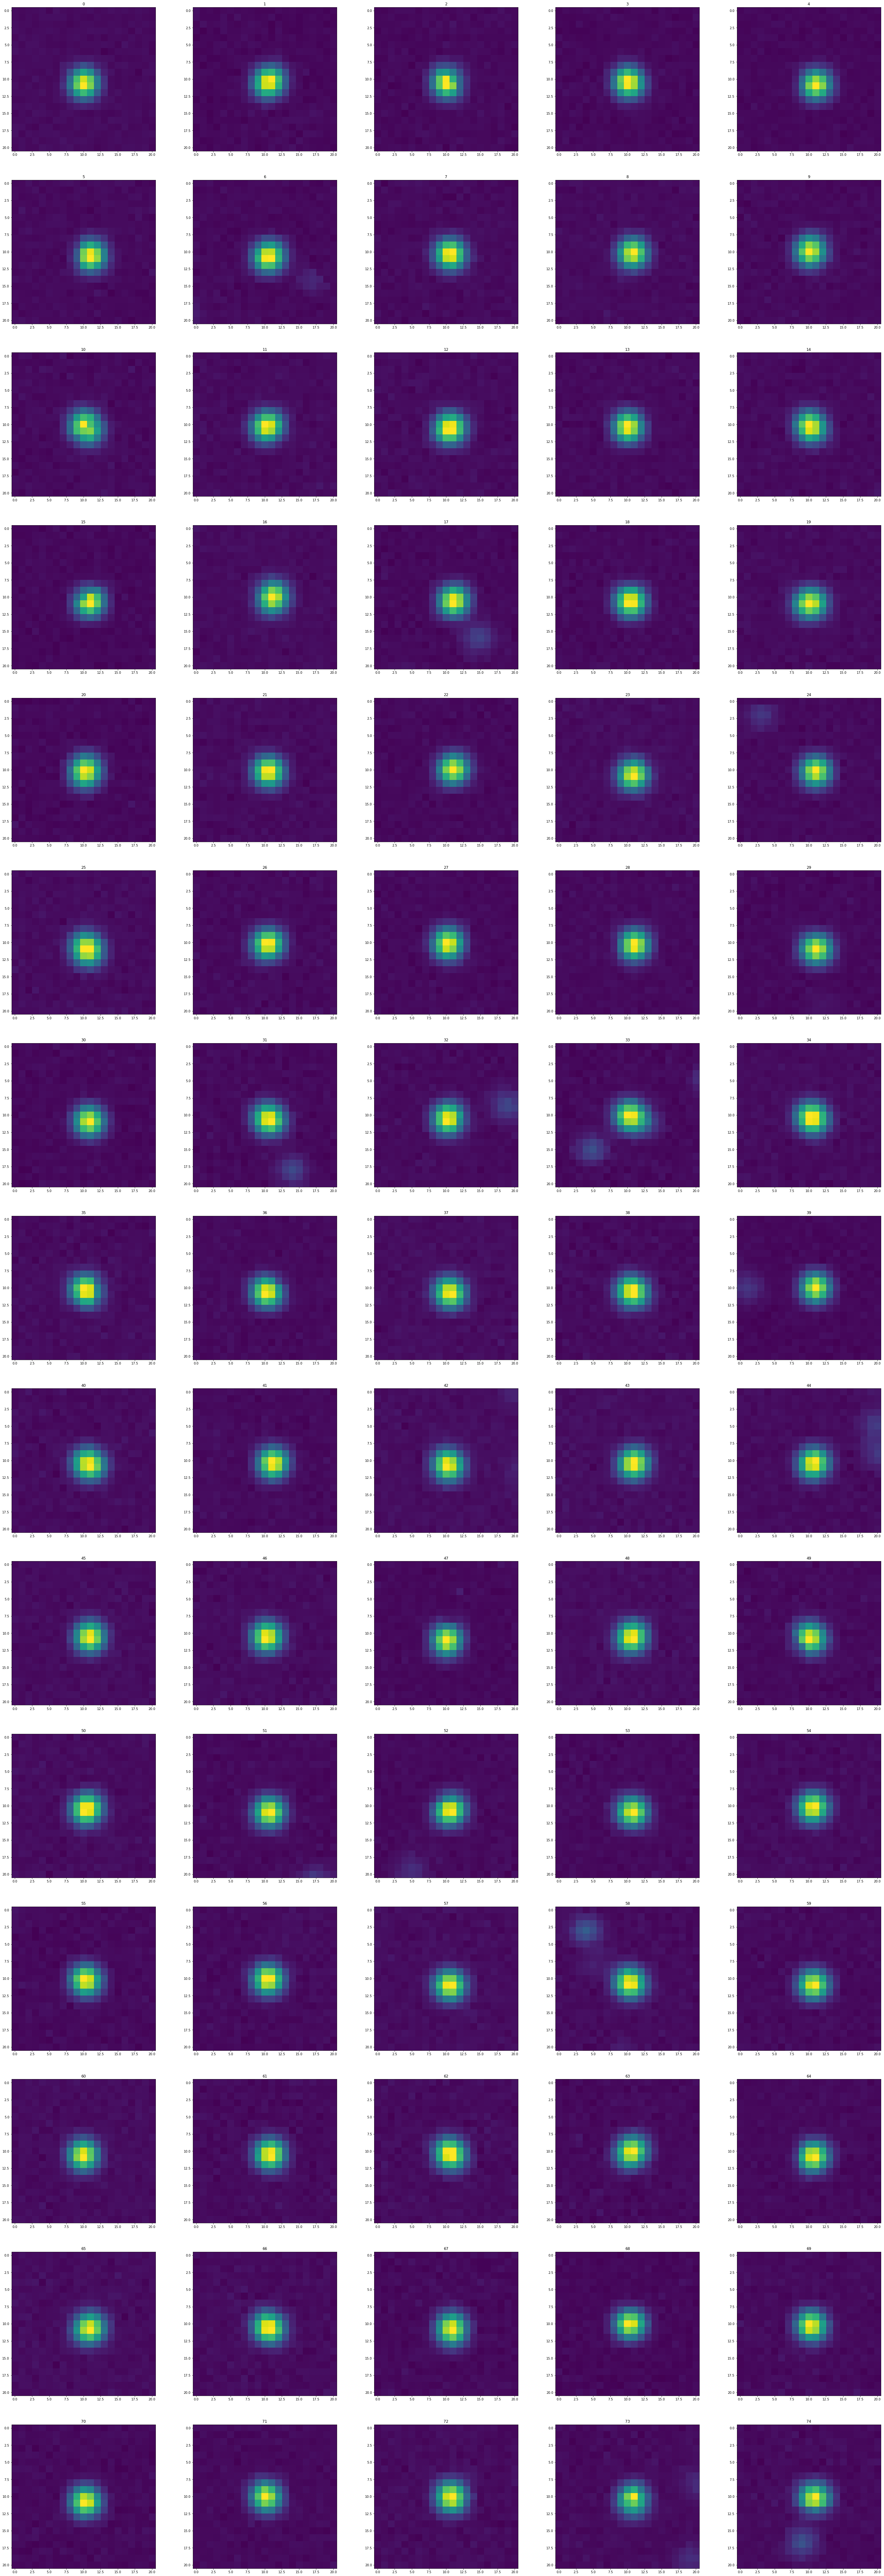

In [35]:
fig = plt.figure(figsize=(50, 150))
set_on = 1
plot_count = 75
print ('Starting at %i' % int((set_on - 1)*plot_count))
for i in range((set_on-1)*plot_count,set_on*plot_count):
    fig.add_subplot(15,5,i-(set_on-1)*plot_count+1)
    plt.imshow(stamps[i], #cmap=plt.cm.Greys_r, 
               interpolation=None)
    plt.title(str(i))

In [36]:
def plot_histogram(results_to_plt, bins, x_rng, y_rng, name, title, color):
# the histogram of the data
    n, bins, patches = plt.hist(np.array(results_to_plt), bins, normed=0, facecolor=color, alpha=0.75)

    # add a 'best fit' line
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.xlabel(name)
    plt.ylabel('Detections')
    plt.title(title)
    plt.axis([*x_rng, *y_rng])
    plt.grid(True)

    plt.show()

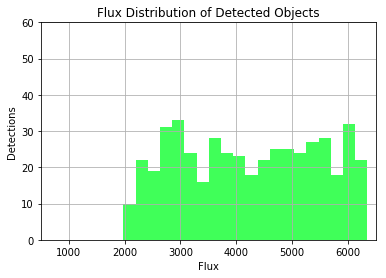

In [37]:
plot_histogram([t.flux for t in results_to_plot], 20, 
flux_range, (0,60), 'Flux', 'Flux Distribution of Detected Objects', '#00ff22')

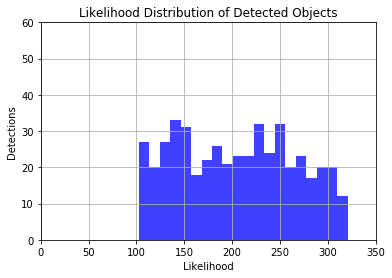

In [44]:
plot_histogram([t.lh for t in results_to_plot], 20, 
(0, 350), (0,60), 'Likelihood', 'Likelihood Distribution of Detected Objects', 'blue')

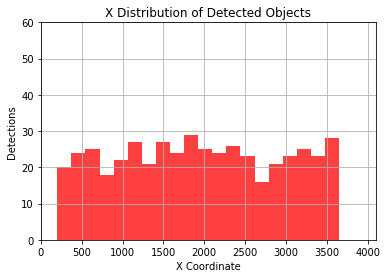

In [39]:
plot_histogram([t.x for t in results_to_plot], 20,
(0, 4096), (0,60), 'X Coordinate', 'X Distribution of Detected Objects', 'red')

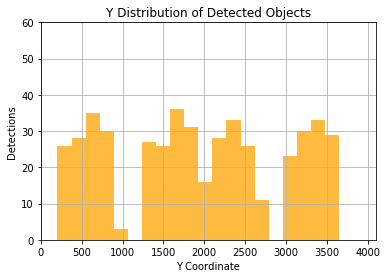

In [40]:
plot_histogram([t.y for t in results_to_plot], 20, 
(0, 4096), (0,60), 'Y Coordinate', 'Y Distribution of Detected Objects', 'orange')